In [1]:
import numpy as np
import pandas as pd
import datetime
from fbprophet import Prophet
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")


def get_str_periodos(per_number):
    min_ = str(per_number)
    min_str=min_[0:4]+'-'+min_[4:6]
    return_index=pd.to_datetime(min_str,format='%Y-%m',errors='coerce')
    return return_index

def get_changepoint_idx(length, n_changepoints, changepoint_range = 0.8): # 0.8 is the Prophet default – do not create changepoints in the last 20% of the data
    historical_size = int(np.floor(length * changepoint_range)) # length of relevant area
    return np.linspace(0, historical_size -1, n_changepoints+1).round().astype(int)[1:]

def make_changepoint_features(n, changes_idx):
    linear = np.arange(n).reshape(-1,1)
    features = [linear]
    for i in changes_idx:
        slope_features = np.zeros(n)
        slope_features[i:] = np.arange(0, n-i)
        slope_features = slope_features.reshape(-1,1)
        features.append(slope_features)
    features = np.concatenate(features, axis=1)
    return features

ds=pd.read_csv('./data/data-octubre.csv',sep=';',decimal=",")



In [2]:
ds['return_index']=ds['Periodo'].apply(lambda x: get_str_periodos(x))
ds=ds[['return_index','MONTO_NETO']] 
ds.columns=['ds','y']

In [3]:
# run Prophet
changepoint_prior_scale = 0.3
m = Prophet(n_changepoints=15, changepoint_prior_scale=changepoint_prior_scale, growth='linear', uncertainty_samples=None, yearly_seasonality=False)



In [4]:
m.fit(ds)
forecast = m.predict(ds)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -29.3345
Iteration  1. Log joint probability =    28.6366. Improved by 57.9711.
Iteration  2. Log joint probability =    47.5345. Improved by 18.8979.
Iteration  3. Log joint probability =    55.2891. Improved by 7.75459.
Iteration  4. Log joint probability =    56.6257. Improved by 1.33667.
Iteration  5. Log joint probability =    63.9915. Improved by 7.36574.
Iteration  6. Log joint probability =    64.2142. Improved by 0.222751.
Iteration  7. Log joint probability =    64.4763. Improved by 0.262042.
Iteration  8. Log joint probability =    64.7101. Improved by 0.23386.
Iteration  9. Log joint probability =    64.7267. Improved by 0.0165633.
Iteration 10. Log joint probability =       64.8. Improved by 0.0733436.
Iteration 11. Log joint probability =    64.8139. Improved by 0.0138907.
Iteration 12. Log joint probability =    64.8934. Improved by 0.0794956.
Iteration 13. Log joint probability =     64.949. Improved by 0.0555818.
Iteration 14. Log joint

In [5]:
initial_slope = m.params['k'][0]
initial_slope

array([0.71799273])

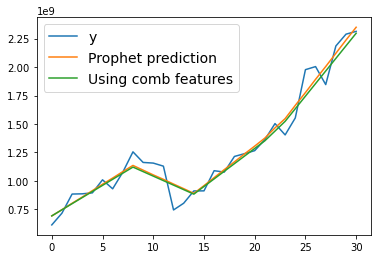

In [6]:
# extract the learned parameters from the model
initial_slope = m.params['k'][0]
intercept = m.params['m'][0]
deltas_coefs = m.params['delta'][0]
features_coefs = np.concatenate([initial_slope, deltas_coefs])

scale = ds.y.max() # Prophet scales the data by dividing by the max value before prediction, we will multiple by it to get to the original scale
idx = get_changepoint_idx(len(ds), 15)
comb_features = make_changepoint_features(len(ds), idx)/len(ds)

ds.y.plot()
forecast.yhat.plot(label='Prophet prediction')
pd.Series(((comb_features * features_coefs).sum(axis=1) +intercept) * scale).plot(label='Using comb features')
plt.legend(fontsize=14)

In [7]:
from sklearn import linear_model

In [8]:
esimtated_sigma = 0.3
# Sklearn’s Lasso divided the error-loss by 2n, so the regularization term must be divided by 2n as well
alpha = esimtated_sigma**2/(changepoint_prior_scale * len(ds))
lr = linear_model.Lasso(alpha=alpha)
lr.fit(comb_features, ds['y'])
pred = lr.predict(comb_features)

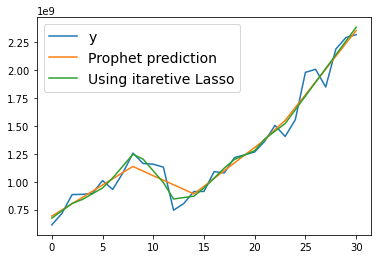

In [9]:
ds.y.plot()
forecast.yhat.plot(label='Prophet prediction')
pd.Series(pred).plot(label='Using itaretive Lasso')
plt.legend(fontsize=14)

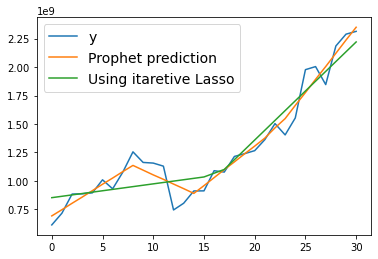

In [15]:
def lasso_by_laplace_prior(X, y, b, max_iter = 5, est_sigma = 1):
    n = len(y)
    for i in range(max_iter):
        reg_alpha = est_sigma**2 / (b * n)
        lr = linear_model.Lasso(alpha=reg_alpha, fit_intercept=True)
        lr.fit(X, y)
        est_sigma = (lr.predict(X) - y).std()
    return lr

changepoint_prior_scale=0.1
lr = lasso_by_laplace_prior(comb_features, ds.y / scale, changepoint_prior_scale)
pred = lr.predict(comb_features) * scale

ds.y.plot()
forecast.yhat.plot(label='Prophet prediction')
pd.Series(pred).plot(label='Using itaretive Lasso')
plt.legend(fontsize=14)